In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## a)Create your own dataset for text classification. It should contain at least 1000 words in total and at least two categories with at least 100 examples per category. You can create it by scraping the web or using some of the documents you have on your computer (do not use anything confidential). Loading the dataset below.

## We scraped data from IMDB website on movie ratings and assigned the label from the rating mentioned by the user.

In [32]:
%%capture
!pip install selenium

In [2]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd
import os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

Mounted at /content/drive


In [ ]:
#BLONDE MOVIE
# movie_link = "https://www.imdb.com/title/tt1655389/reviews/?ref_=ttrt_sa_3"

#DUNGEONS AND DRAGONS
# movie_link = "https://www.imdb.com/title/tt2906216/reviews/?ref_=ttrt_sa_3"

#THE POPE EXORCIST
# movie_link = "https://www.imdb.com/title/tt13375076/reviews?ref_=tt_sa_3"

#SCREAM VI
movie_link = "https://www.imdb.com/title/tt17663992/reviews?ref_=tt_sa_3"
num_reviews = 1000

In [ ]:
driver = webdriver.Chrome('chromedriver_win32/chromedriver.exe')
driver.get(movie_link)
driver.maximize_window()

last_height = driver.execute_script("return document.body.scrollHeight")

cnt_load_more = 0
while True:
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight-250);')
    try:
        load_button = driver.find_element(By.CLASS_NAME,'ipl-load-more__button')
        load_button.click()
        time.sleep(2) 
        cnt_load_more+=1
        if cnt_load_more==15: break  
    except:
        break

driver.execute_script('window.scrollTo(0, 100);')

reviews_list = []

for i in tqdm(range(1,num_reviews+1)):
    try:
        revs = driver.find_element(By.XPATH,f'//*[@id="main"]/section/div[2]/div[2]/div[{i}]/div[1]') 
    except:
        continue
    try:
        rating = revs.find_element(By.CLASS_NAME,"rating-other-user-rating").text.split("/")[0]
        contents = revs.find_element(By.CLASS_NAME,"content").text
        if contents == "":
            contents = revs.find_element(By.CLASS_NAME,"text show-more__control clickable").text
        re.sub('\n',' ',contents)
        re.sub('\t',' ',contents)
        contents.replace("//","")
        reviews_list.append(
            [revs.find_element(By.CLASS_NAME,"review-date").text,
             contents,
             rating]
            )
    except:
        pass
driver.quit()

In [ ]:
dates = [r[0] for r in reviews_list]
cont = [r[1] for r in reviews_list]
rat = [r[2] for r in reviews_list]

df = pd.DataFrame(columns=['Dates','Content',"Rating"])
df['Dates'] = dates
df['Content'] = cont
df['Rating'] = rat

df.head()

In [ ]:
df['Rating'] = pd.to_numeric(df['Rating'])
output_path = "Movie_Ratings.csv"
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))


In [3]:
ratings_df = pd.read_csv("/content/drive/MyDrive/Movie_Ratings.csv",index_col=0)

ratings_df.head()

,Dates,Content,Rating
0,24 September 2022,What a truly disappointing film this is. It of...,5
1,7 October 2022,If you're going to fictionalize the life of on...,5
2,28 September 2022,"""Blonde"" is sadly reduced to the collective tr...",4
3,28 September 2022,Greetings again from the darkness. For those w...,7
4,28 September 2022,I have no idea how accurate this account of Ma...,7


## The dataset contains movie reviews along with ratings given by the user rating from 1-10. Next, we have divided the ratings into 3 main labels - 1-3 : Negative 4-7 : Neutral 8-10 : Positive

In [4]:
def conditions(ratings_df):
    if 1<=ratings_df['Rating']<=3: return 0
    if 4<=ratings_df['Rating']<=7: return 1
    if 8<=ratings_df['Rating']<=10: return 2

ratings_df['Ratings_Col'] = ratings_df.apply(conditions,axis=1)

<Axes: >

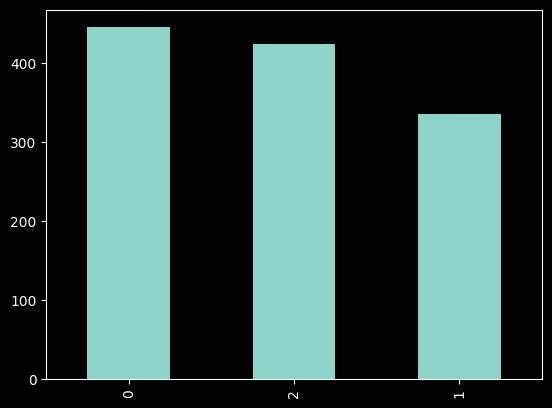

In [5]:
plt.style.use('dark_background')
ratings_df['Ratings_Col'].value_counts().plot(kind="bar")

In [6]:
%%capture
!pip install transformers
!pip install datasets
!pip install evaluate

In [7]:
from transformers import GPT2Tokenizer,BertTokenizer

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
ratings_df.head()

,Dates,Content,Rating,Ratings_Col
0,24 September 2022,What a truly disappointing film this is. It of...,5,1
1,7 October 2022,If you're going to fictionalize the life of on...,5,1
2,28 September 2022,"""Blonde"" is sadly reduced to the collective tr...",4,1
3,28 September 2022,Greetings again from the darkness. For those w...,7,1
4,28 September 2022,I have no idea how accurate this account of Ma...,7,1


## b) Split the dataset into training (at least 160examples) and test (at least 40 examples) sets.

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df['Ratings_Col'],random_state=22)
train, val = train_test_split(train, test_size=0.1, stratify=train['Ratings_Col'], random_state=22)

In [ ]:
train=ratings_df.sample(frac=0.8,random_state=42)
test=ratings_df.drop(train.index)
val = train.sample(frac=0.1,random_state=42)
train.drop(val.index,inplace=True)

In [11]:
train.rename({'Ratings_Col':'labels','Content':'text'},inplace=True,axis="columns")
test.rename({'Ratings_Col':'labels','Content':'text'},inplace=True,axis="columns")
val.rename({'Ratings_Col':'labels','Content':'text'},inplace=True,axis="columns")

In [12]:
train = train[['labels','text']]
test = test[['labels','text']]
val = test[['labels','text']]

In [13]:
train.to_csv('train_ratings.csv',index=False)
test.to_csv('test_ratings.csv',index=False)
val.to_csv('val_ratings.csv',index=False)

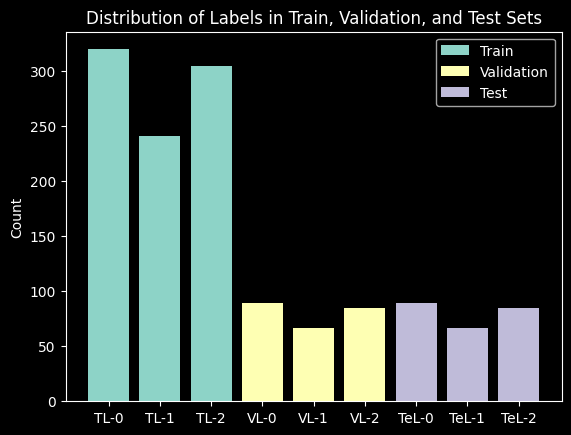

In [20]:
train_cnt = [sum(train['labels'] == i) for i in range(3)]
val_cnt = [sum(val['labels'] == i) for i in range(3)]
test_cnt = [sum(test['labels'] == i) for i in range(3)]

fig, ax = plt.subplots()
ax.bar(['TL-0', 'TL-1', 'TL-2'], train_cnt, label='Train')
ax.bar(['VL-0', 'VL-1', 'VL-2'], val_cnt, label='Validation')
ax.bar(['TeL-0', 'TeL-1', 'TeL-2'], test_cnt, label='Test')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels in Train, Validation, and Test Sets')
ax.legend()
plt.show()


In [21]:
from datasets import load_dataset

dataset = load_dataset("csv",data_files={"train":"train_ratings.csv","val":"val_ratings.csv","test":"test_ratings.csv"})

  0%|          | 0/3 [00:00<?, ?it/s]

## c) Fine tune a pretrained language model capable of generating text (e.g., GPT) that you can take from the Hugging Face Transformers library with the dataset your created (I suggest using this tutorial: https://huggingface.co/docs/transformers/training). Report the test accuracy. Discuss what could be done to improve accuracy.

In [22]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenized_datasets = dataset.map(tokenize_function)

In [23]:
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]
val_dataset = tokenized_datasets["val"]

In [24]:
from transformers import GPT2ForSequenceClassification,GPT2Config, BertForSequenceClassification
num_labels = 3
# model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
import evaluate

metric = evaluate.load(
    "accuracy",
    "precision"
)

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import TrainingArguments,Trainer

training_args = TrainingArguments(output_dir="/content/drive/MyDrive", evaluation_strategy="epoch",num_train_epochs= 10
                                  ,do_train=True,do_predict=True,logging_dir="/content/drive/MyDrive/imdb_tensorboad",
                                  metric_for_best_model="accuracy",load_best_model_at_end = True,save_strategy="epoch",
                                  logging_first_step=True)

In [28]:
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(5)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset = val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback]
)

In [29]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.158200,0.748210,0.676349
2,1.158200,0.748655,0.701245
3,1.158200,0.960544,0.659751
4,1.158200,1.177972,0.721992
5,0.528600,1.901685,0.651452
6,0.528600,1.766410,0.726141
7,0.528600,1.991919,0.692946
8,0.528600,2.029479,0.688797
9,0.528600,2.016320,0.709544
10,0.022800,2.028873,0.709544


TrainOutput(global_step=1090, training_loss=0.25354081522160715, metrics={'train_runtime': 974.4618, 'train_samples_per_second': 8.887, 'train_steps_per_second': 1.119, 'total_flos': 2278562197524480.0, 'train_loss': 0.25354081522160715, 'epoch': 10.0})

## SUMMARY
1. The train and validation loss are close to each other, so the learning curve is smooth and there are conditions for overfitting
2. The best validation accuracy is 72.6%

In [ ]:
trainer.save_model("/content/drive/MyDrive/imdb_model")
# trainer.save_state("/content/drive/MyDrive/imdb_state")

## PREDICTION OF TEST SET

In [30]:
# trainer.compute_metrics(test_dataset)
test_outputs = trainer.predict(test_dataset)

In [31]:
test_outputs[2]

{'test_loss': 1.7664101123809814,
 'test_accuracy': 0.7261410788381742,
 'test_runtime': 8.0159,
 'test_samples_per_second': 30.065,
 'test_steps_per_second': 3.867}

## SUMMARY FOR TEST SET IMPROVEMENTS
1. The test set accuracy is 72.6%

IMPROVEMENTS
1. We can add more data to our dataset to fine-tune with the pre-trained model
2. We can try other State-of-the-art of models comapred to BerT like RoberTa, BART and other language models
3. Tuning the hyperparameters like learning rate, max sequence length and model dimension.